### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [11]:
!nvidia-smi

Sun Nov 30 16:43:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [12]:
import os
HOME = "/content"
dataset_dir = os.path.join(HOME, "datasets")

os.makedirs(dataset_dir, exist_ok=True)
%cd {dataset_dir}

/content/datasets


## Install YOLO11 via Ultralytics

In [13]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.1/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [15]:

%cd {HOME}/datasets
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="dopKtqTf1nmvUXVy0pPr")
project = rf.workspace("acne-dqmyr").project("acne-detection-hjgkp")
version = project.version(9)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Acne-detection-9 in yolov11:: 100%|██████████| 5160/5160 [00:00<00:00, 8534.26it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [16]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

In [10]:
!ls -R



.:
sample_data

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


## Custom Training

In [17]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/Acne-detection-9/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [19]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg		val_batch0_pred.jpg
BoxF1_curve.png			 results.csv		val_batch1_labels.jpg
BoxP_curve.png			 results.png		val_batch1_pred.jpg
BoxPR_curve.png			 train_batch0.jpg	val_batch2_labels.jpg
BoxR_curve.png			 train_batch1.jpg	val_batch2_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	weights
confusion_matrix.png		 val_batch0_labels.jpg


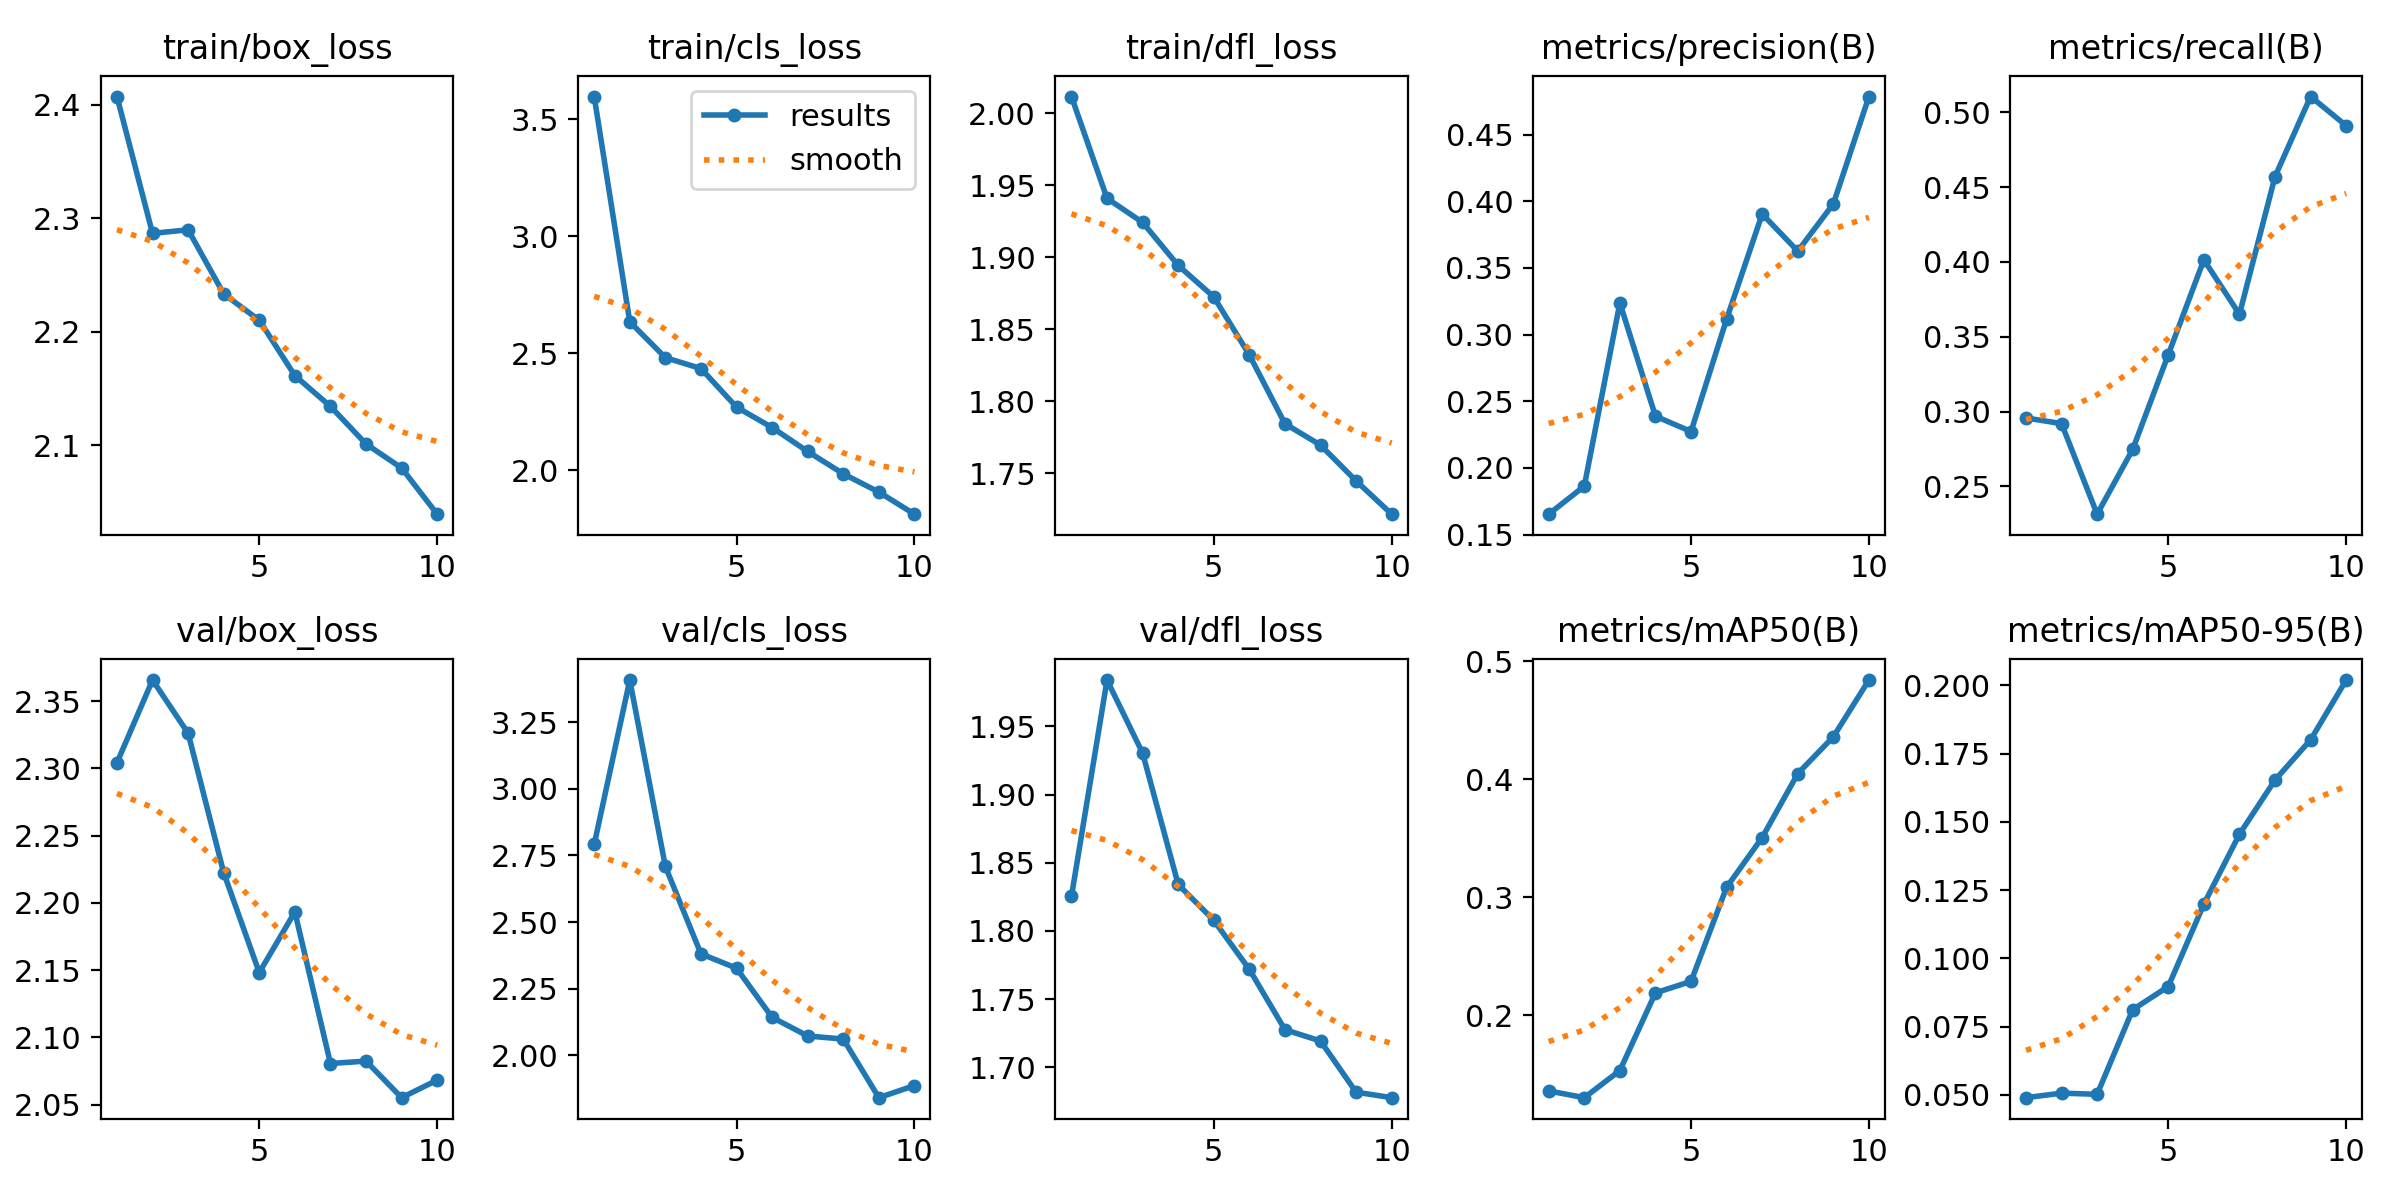

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [21]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1032.2±243.4 MB/s, size: 28.4 KB)
val: Scanning /content/datasets/Acne-detection-9/valid/labels.cache... 177 images, 9 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 177/177 2.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.9it/s 4.1s
                   all        177       1199      0.479      0.489      0.485      0.202
               Pustula         31         96      0.377        0.5      0.461      0.184
        acne fulminans         10         18      0.612      0.352      0.504      0.169
             blackhead         33        419       0.67      0.327      0.499      0.192
           fungal acne         17         19      0.337      0.632      0.408      0.182
               nodules      

## Inference with custom model

In [22]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs

image 1/114 /content/datasets/Acne-detection-9/test/images/174_jpeg.rf.fa01bfe90ec2c1efc2d04fdcf40032a8.jpg: 640x640 2 noduless, 15.7ms
image 2/114 /content/datasets/Acne-detection-9/test/images/178_jpeg.rf.7e2d3de1b8dd8d5ccacac49718a65087.jpg: 640x640 1 nodules, 15.6ms
image 3/114 /content/datasets/Acne-detection-9/test/images/1950af49-5b33-4b3f-b95f-2235cc72a6f8_jpeg.rf.34852a84ce2c2dc2713f88d8259709a3.jpg: 640x640 (no detections), 15.5ms
image 4/114 /content/datasets/Acne-detection-9/test/images/196511b7-15ef-417d-b05e-e0e6d49ff518_jpeg.rf.683d366d4b6e12efeae8343658665348.jpg: 640x640 3 noduless, 15.5ms
image 5/114 /content/datasets/Acne-detection-9/test/images/273763f3-d0f3-4b0f-a87b-7f39129b462e_jpeg.rf.607e6579d79d34a7d853c80170bb28bb.jpg: 640x640 2 papulas, 15.5ms
image 6/114 /content/datasets/Acne-detection-9/tes

**NOTE:** Let's take a look at few results.

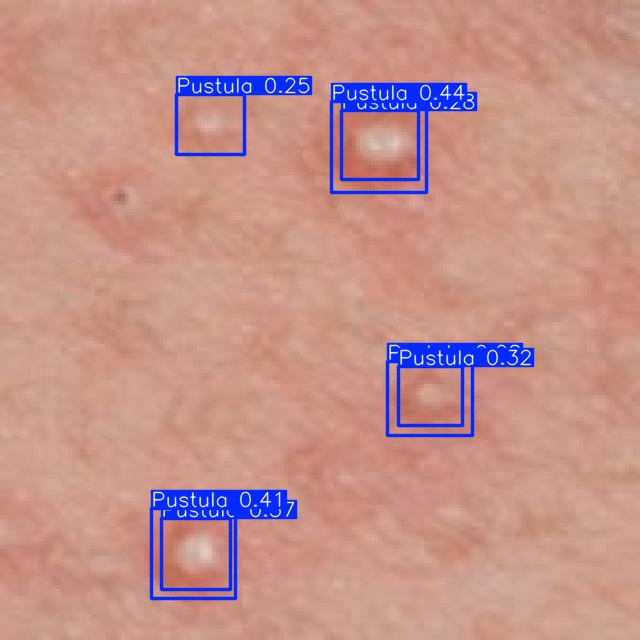

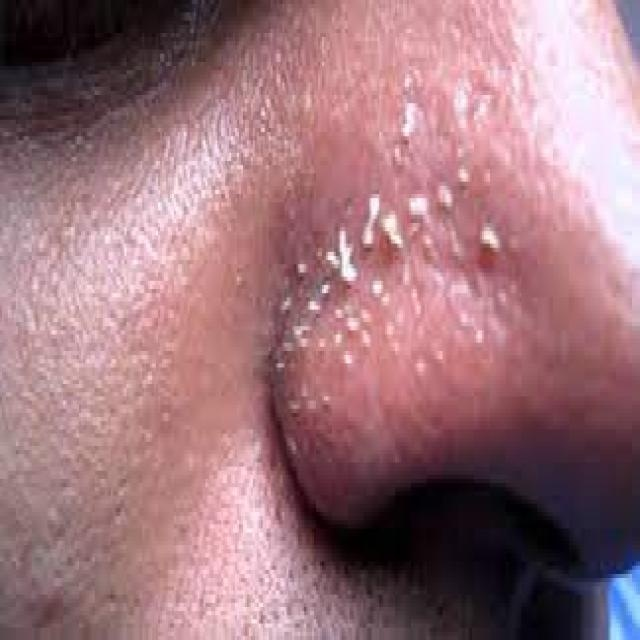

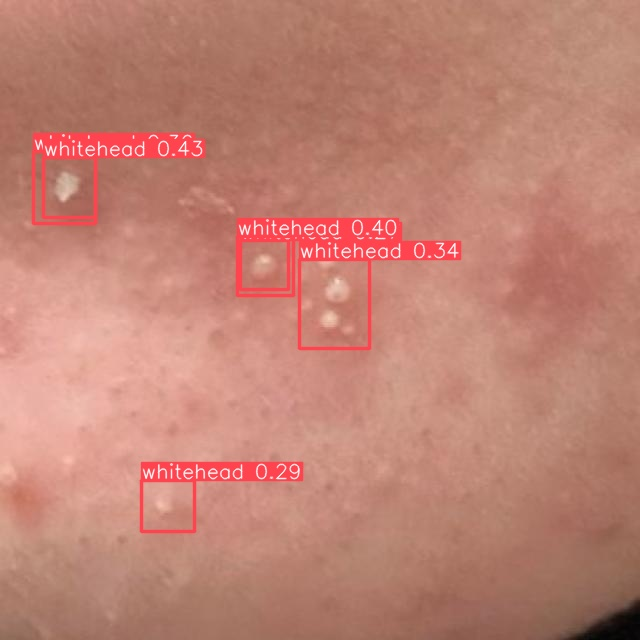

In [23]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")